## Importing Libraries

In [2]:
import pubchempy as pcp
import pandas as pd
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import tree
import graphviz
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from rdkit import Chem
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import copy
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras

# Apply the default theme
sns.set_theme()

warnings.filterwarnings("ignore")

## Getting Data Using APIs

In [3]:
df = pd.read_csv('/content/Assay List CCTE_Padilla_ZF_144hpf_TERATOSCORE_up-2022-11-07 (2).csv')

In [4]:
print("Number of inactive cases is: ", df.where(df["HIT CALL"] == "Inactive").count()[0])
print("Number of active cases is: ", df.where(df["HIT CALL"] == "Active").count()[0])

Number of inactive cases is:  223
Number of active cases is:  497


In [5]:
df.isnull().any()

DTXSID               False
PREFERRED NAME       False
CASRN                False
MOLECULAR FORMULA     True
MONOISOTOPIC MASS    False
ToxCast Active       False
ToxCast Total        False
% ToxCast Active     False
HIT CALL             False
TOP                   True
SCALED TOP            True
AC50                  True
LOGAC50               True
dtype: bool

In [6]:
df = df.drop(columns=["ToxCast Active", "ToxCast Total", "% ToxCast Active", "CASRN", "TOP", "SCALED TOP", "LOGAC50", "AC50", "DTXSID", 'MOLECULAR FORMULA', 'MONOISOTOPIC MASS'])

In [7]:
df.dropna(inplace=True)
df.head(3)

,PREFERRED NAME,HIT CALL
0,Sodium L-ascorbate,Active
1,Chlorothalonil,Active
2,Acifluorfen,Inactive


In [8]:
compounds = []
for i in df["PREFERRED NAME"]:
  try:
    compounds.append(pcp.get_compounds(i, 'name'))
    time.sleep(0.1)
  except TypeError or URLError:
    print(i)

In [9]:
df['compounds'] = compounds
df.head(3)

,PREFERRED NAME,HIT CALL,compounds
0,Sodium L-ascorbate,Active,[Compound(23667548)]
1,Chlorothalonil,Active,[Compound(15910)]
2,Acifluorfen,Inactive,[Compound(44073)]


In [10]:
df = df.where(df["compounds"].str.len() == 1).dropna()

In [11]:
for index, row in df.iterrows():
  c = row["compounds"][0]
  df.loc[index, 'Hydrogen_Bond_Donor_Count'] = c.h_bond_donor_count
  df.loc[index, 'Hydrogen_Bond_Acceptor_Count'] = c.h_bond_acceptor_count
  df.loc[index, 'Formal_Charge'] = c.charge
  df.loc[index, 'Mw'] = c.molecular_weight
  df.loc[index, 'canonical_smiles'] = c.canonical_smiles
  df.loc[index, 'xlogp'] = c.xlogp
  df.loc[index, 'exact_mass'] = c.exact_mass

<Axes: >

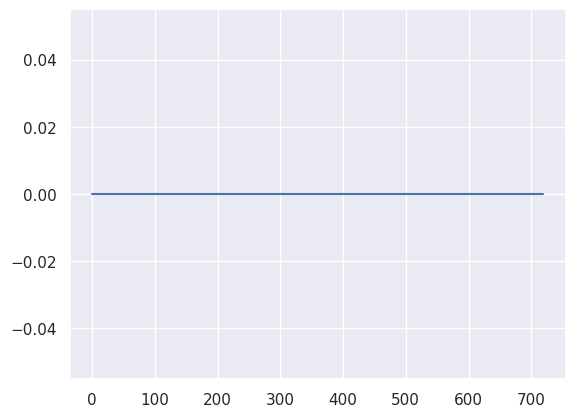

In [12]:
df["Formal_Charge"].plot()

In [13]:
df = df.drop(columns=['Formal_Charge'])

In [14]:
mols = []
df.dropna()
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
for smiles in df["canonical_smiles"]:
  mol = Chem.MolFromSmiles(smiles)
  mols.append(mol)

df["mol"] = mols

for index, row in df.iterrows():
  mol = row["mol"]
  df.loc[index,'NumHeteroatoms'] = Descriptors.NumHeteroatoms(mol)
  df.loc[index,'NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
  df.loc[index,'NumHeavyAtoms'] = Descriptors.HeavyAtomCount (mol)
  df.loc[index,'NumAliphaticCarbocycles'] = Descriptors.NumAliphaticCarbocycles(mol)
  df.loc[index,'NumAliphaticHeterocycles'] = Descriptors.NumAliphaticHeterocycles(mol)
  df.loc[index,'NumAliphaticRings'] = Descriptors.NumAliphaticRings(mol)
  df.loc[index,'NumAromaticCarbocycles'] = Descriptors.NumAromaticCarbocycles(mol)
  df.loc[index,'NumAromaticHeterocycles'] = Descriptors.NumAromaticHeterocycles(mol)
  df.loc[index,'NumAromaticRings'] = Descriptors.NumAromaticRings(mol)
  df.loc[index,'RingCount'] = Descriptors.RingCount(mol)
  df.loc[index,'FractionCSP3'] = Descriptors.FractionCSP3(mol)
  df.loc[index,'NHOHCount'] = Descriptors.NHOHCount(mol)
  df.loc[index,'NOCount'] = Descriptors.NOCount(mol)
  df.loc[index,'NumValenceElectrons'] = Descriptors.NumValenceElectrons(mol)
  df.loc[index,'TPSA'] = Descriptors.TPSA(mol)

In [15]:
df.dropna(inplace=True)
df.head(3)

,PREFERRED NAME,HIT CALL,compounds,Hydrogen_Bond_Donor_Count,Hydrogen_Bond_Acceptor_Count,Mw,canonical_smiles,xlogp,exact_mass,mol,...,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,RingCount,FractionCSP3,NHOHCount,NOCount,NumValenceElectrons,TPSA
1,Chlorothalonil,Active,[Compound(15910)],0.0,2.0,265.9,C(#N)C1=C(C(=C(C(=C1Cl)Cl)Cl)C#N)Cl,2.9,265.878609,<rdkit.Chem.rdchem.Mol object at 0x7f3fa4381350>,...,0.0,1.0,0.0,1.0,1.0,0.000000,0.0,2.0,70.0,47.58
2,Acifluorfen,Inactive,[Compound(44073)],1.0,8.0,361.65,C1=CC(=C(C=C1C(F)(F)F)Cl)OC2=CC(=C(C=C2)[N+](=...,3.0,360.9964845,<rdkit.Chem.rdchem.Mol object at 0x7f3fa43813c0>,...,0.0,2.0,0.0,2.0,2.0,0.071429,1.0,6.0,126.0,89.67
3,Dichlorprop,Active,[Compound(8427)],1.0,3.0,235.06,CC(C(=O)O)OC1=C(C=C(C=C1)Cl)Cl,3.4,233.9850495,<rdkit.Chem.rdchem.Mol object at 0x7f3fa4381430>,...,0.0,1.0,0.0,1.0,1.0,0.222222,1.0,3.0,76.0,46.53


In [16]:
print("Number of inactive cases is: \t", df.where(df["HIT CALL"] == "Inactive").dropna().count()[0])
print("Number of active cases is: \t", df.where(df["HIT CALL"] == "Active").dropna().count()[0])

Number of inactive cases is: 	 179
Number of active cases is: 	 419


## Cleaning Data and Data Visualization

In [17]:
df['Mw'] = df['Mw'].map(lambda x: float(x))
df['exact_mass'] = df['exact_mass'].map(lambda x: float(x))

In [18]:
features = ['Hydrogen_Bond_Donor_Count',
 'Hydrogen_Bond_Acceptor_Count',
 'Mw',
 'xlogp',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumHeavyAtoms',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'RingCount',
 'FractionCSP3',
 'NHOHCount',
 'NOCount',
 'NumValenceElectrons',
 'TPSA']

In [19]:
df.to_csv("final_output.csv")

In [20]:
for f in features:
  print(f, " stdv: \t\t\t\t", df[f].std())

Hydrogen_Bond_Donor_Count  stdv: 				 0.9515821514152257
Hydrogen_Bond_Acceptor_Count  stdv: 				 3.2001674297806564
Mw  stdv: 				 110.99885681969107
xlogp  stdv: 				 1.9273543439219287
NumHeteroatoms  stdv: 				 3.607009180669758
NumRotatableBonds  stdv: 				 3.386929966812239
NumHeavyAtoms  stdv: 				 7.405786768715443
NumAliphaticCarbocycles  stdv: 				 0.8444044225459753
NumAliphaticHeterocycles  stdv: 				 0.500116231035256
NumAliphaticRings  stdv: 				 1.0119328040268032
NumAromaticCarbocycles  stdv: 				 0.8822754029601932
NumAromaticHeterocycles  stdv: 				 0.5368944585006878
NumAromaticRings  stdv: 				 1.0272010175168853
RingCount  stdv: 				 1.2804445599343506
FractionCSP3  stdv: 				 0.3073196071759205
NHOHCount  stdv: 				 1.1024453436855561
NOCount  stdv: 				 2.436867490332003
NumValenceElectrons  stdv: 				 39.532273352336695
TPSA  stdv: 				 32.62298343525369


In [21]:
df['Mw'].corr(df['exact_mass'])

0.999993679026591

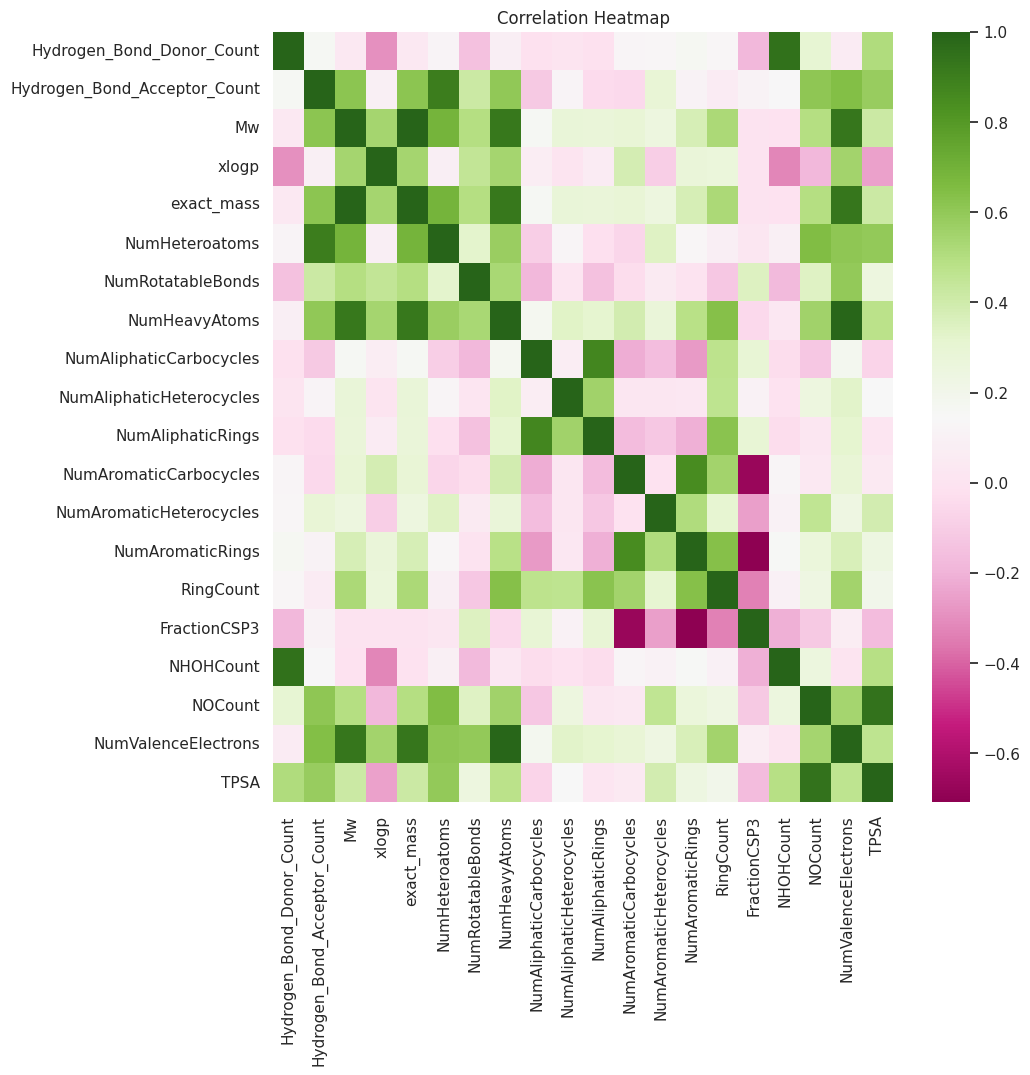

In [22]:
corr_matrix = df.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.color_palette("PiYG", as_cmap=True)
sns.heatmap(corr_matrix, cmap = "PiYG")
plt.title('Correlation Heatmap')
plt.show()

In [23]:
df = df.drop(columns=['PREFERRED NAME', 'mol', 'canonical_smiles', 'compounds', 'exact_mass'])

In [24]:
df.to_csv("final_output.csv")

In [25]:
print(df.groupby("HIT CALL").mean())

          Hydrogen_Bond_Donor_Count  Hydrogen_Bond_Acceptor_Count          Mw  \
HIT CALL                                                                        
Active                     0.725537                      4.157518  304.347351   
Inactive                   1.106145                      4.301676  248.161514   

             xlogp  NumHeteroatoms  NumRotatableBonds  NumHeavyAtoms  \
HIT CALL                                                               
Active    3.756325        5.603819           4.236277      19.983294   
Inactive  2.030726        5.597765           3.798883      16.553073   

          NumAliphaticCarbocycles  NumAliphaticHeterocycles  \
HIT CALL                                                      
Active                   0.336516                  0.195704   
Inactive                 0.162011                  0.206704   

          NumAliphaticRings  NumAromaticCarbocycles  NumAromaticHeterocycles  \
HIT CALL                                             

In [26]:
numerical_features = [
    'NumHeteroatoms', 'NumValenceElectrons', 'NOCount', 'Hydrogen_Bond_Acceptor_Count', 'NumAromaticRings', 'NHOHCount', 'RingCount', 'NumAliphaticRings', 
    'NumAromaticHeterocycles', 'NumAromaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticCarbocycles', 'NumHeavyAtoms', 'NumRotatableBonds'
]

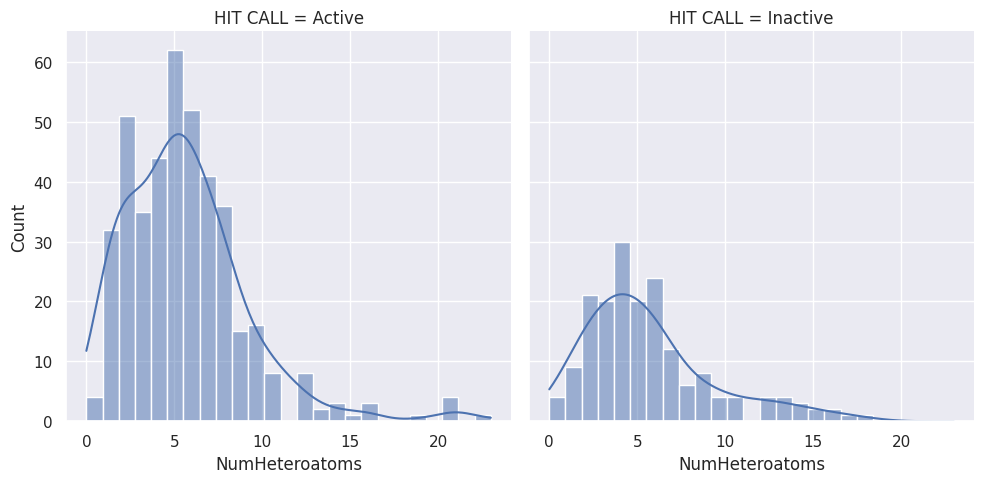

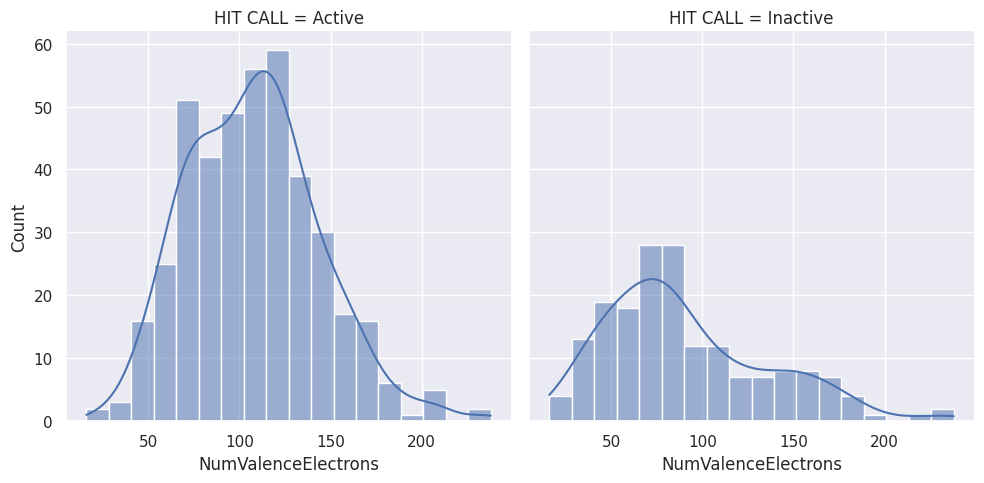

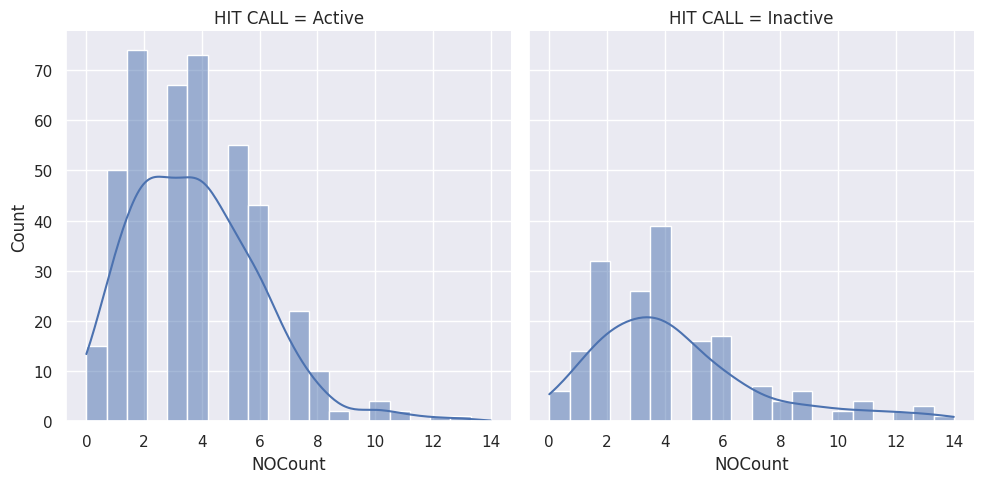

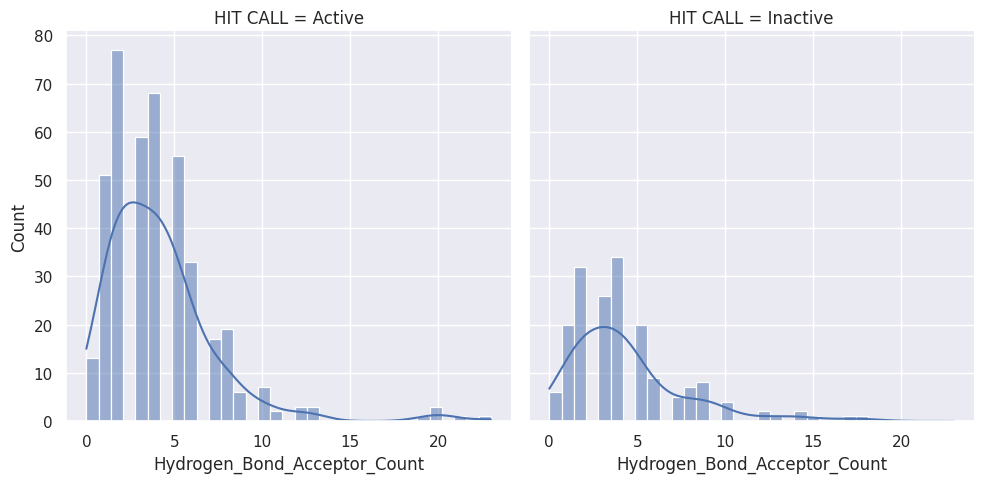

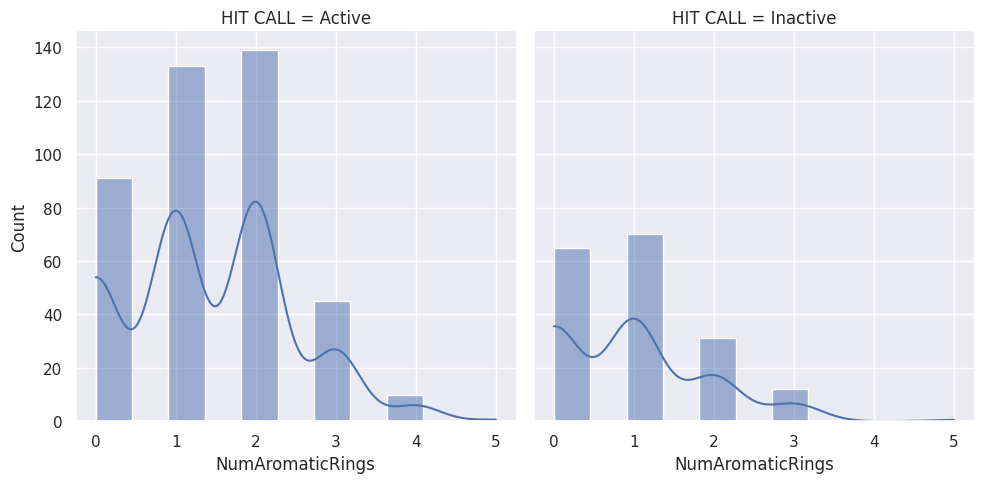

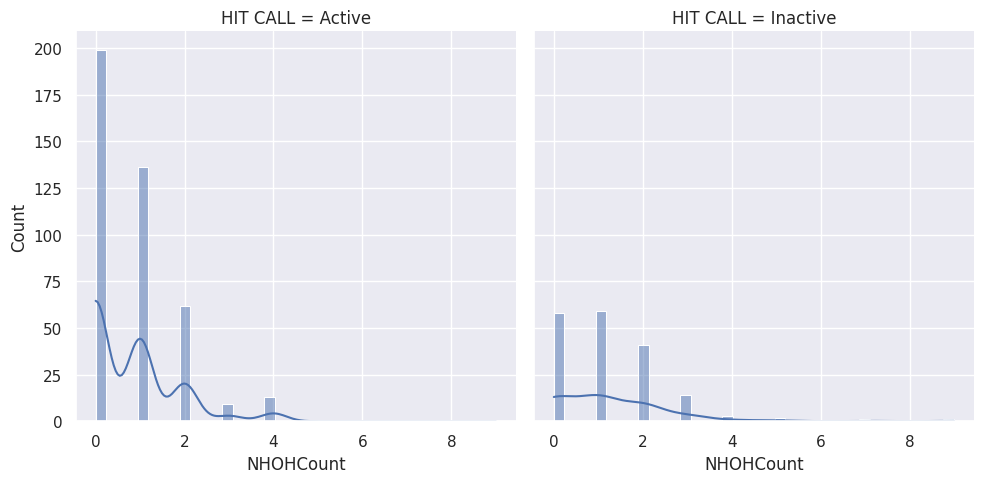

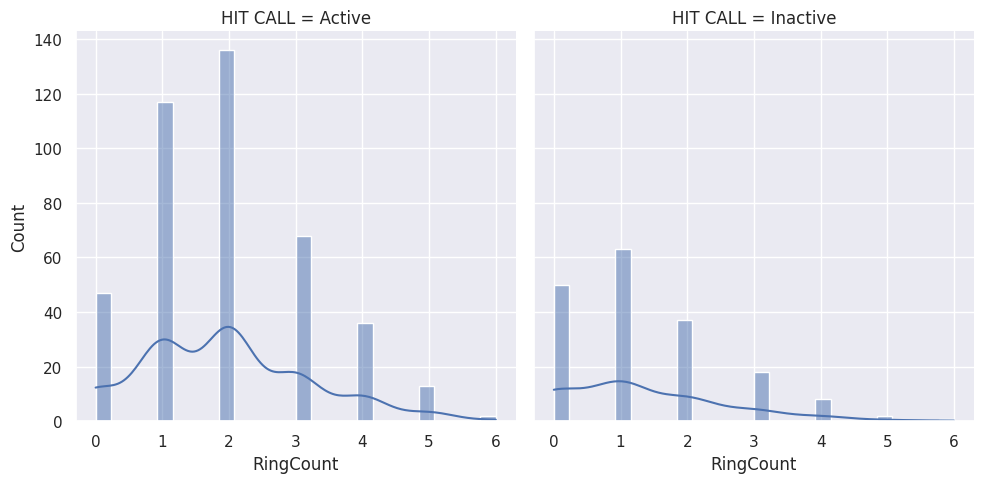

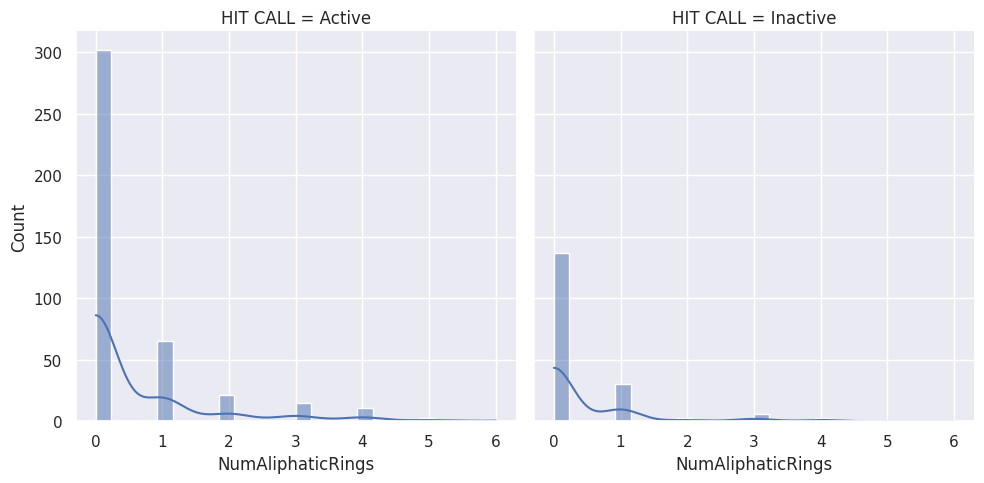

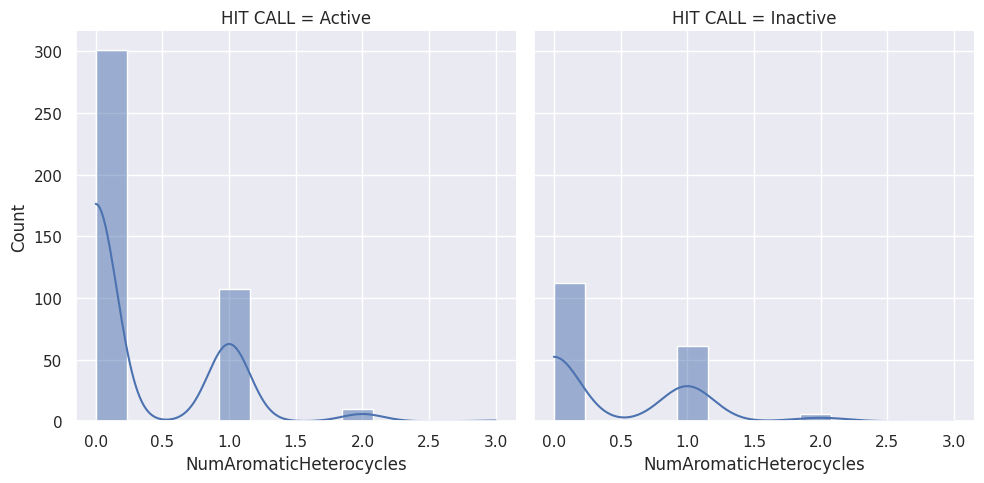

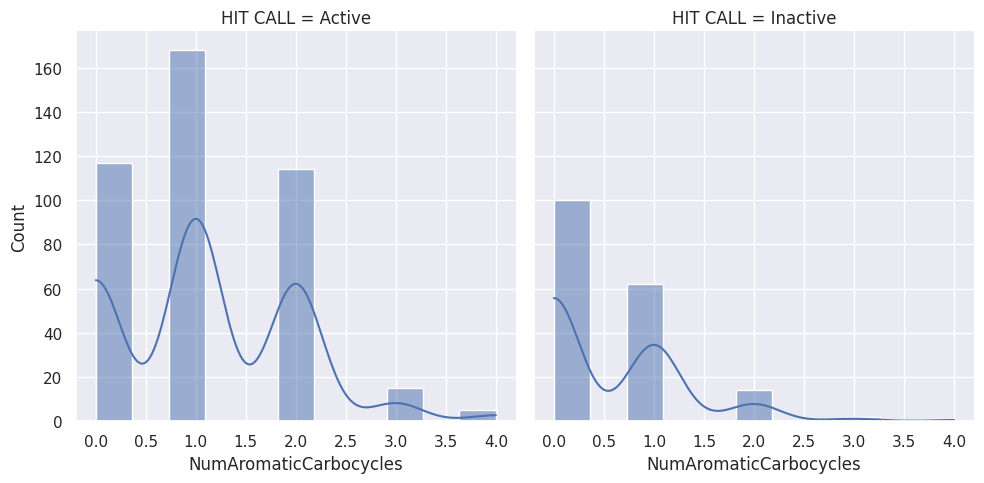

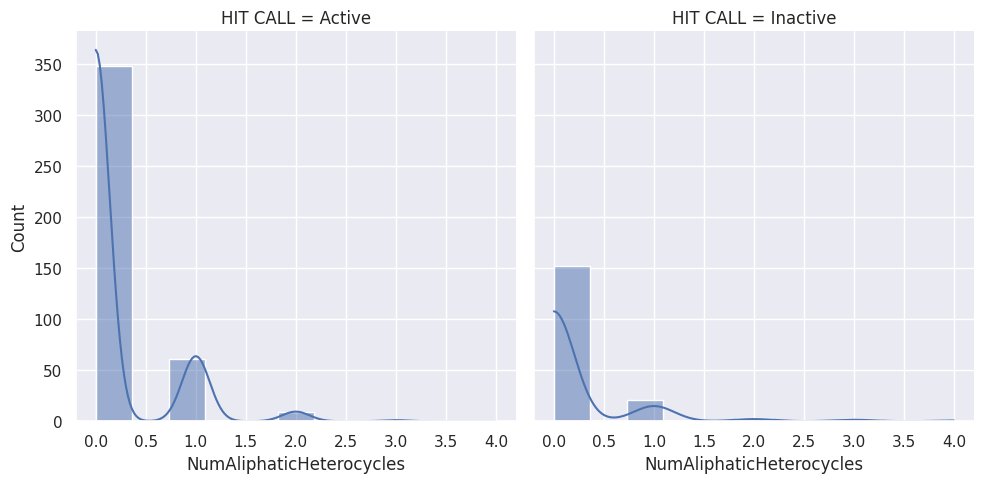

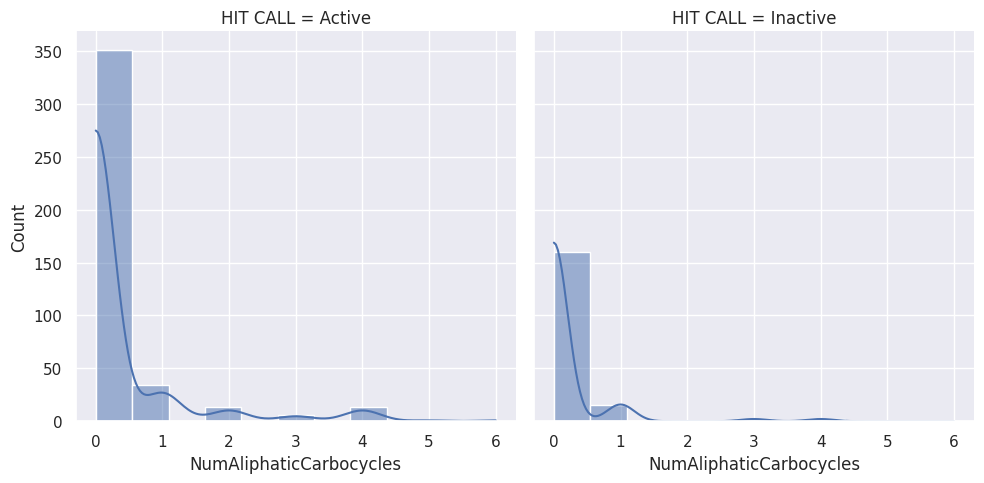

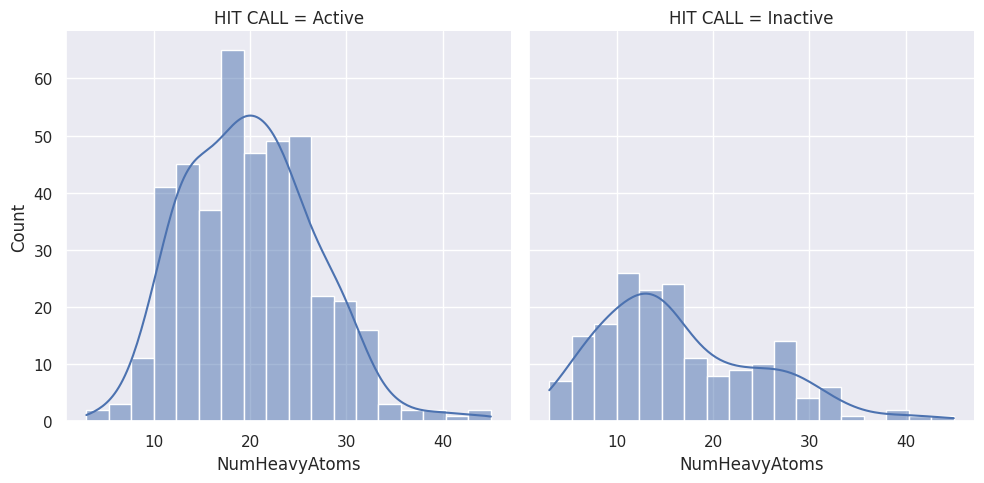

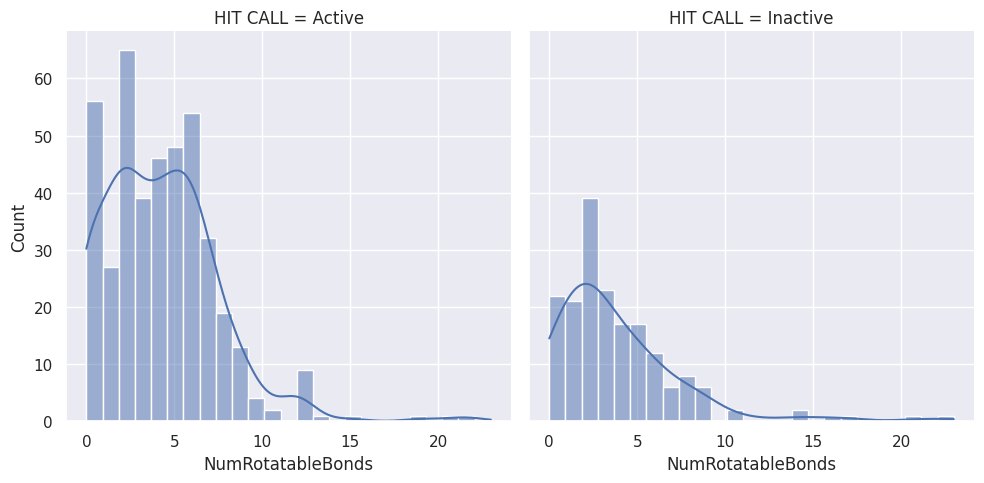

In [27]:
for f in numerical_features:
  sns.displot(data=df, x=f, col="HIT CALL", kde=True)

## Feature Engineering

In [28]:
def has_feature(feature):
  if feature > 0:
    return 1
  else:
    return 0

In [29]:
new_features = []
for f in numerical_features:
  new_name = "Has"
  if 'Count' in f:
    new_name = f.replace("Count", "")
  elif 'Num' in f:
    new_name = f.replace("Num", "")
  new_features.append(new_name)
  df[new_name] = df[f].apply(has_feature)

In [30]:
total_features = new_features + features

In [31]:
X = df[total_features]
y = df["HIT CALL"]

y = y.replace("Active", 1)
y = y.replace("Inactive", 0)

In [32]:
scaler = StandardScaler()
stand_X = copy.deepcopy(X)
stand_X[features] = scaler.fit_transform(X[features])
stand_X = pd.DataFrame(stand_X, index=X.index, columns=X.columns)

In [33]:
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(stand_X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
df.to_csv('final_output.csv')

## Feature Selection

### ANOVA (Analysis of Variance)

In [35]:
f_values, p_values = f_classif(X_train_stand, y_train_stand)

# Create a DataFrame with feature scores and p-values
scores_df = pd.DataFrame({'Feature': X_train_stand.columns, 'F-Score': f_values, 'p-value': p_values})

# Sort the features by F-Score in descending order
scores_df = scores_df.sort_values(by='F-Score', ascending=False)

# Print the sorted DataFrame
print(scores_df)

                         Feature    F-Score       p-value
17                         xlogp  71.735491  4.281474e-16
9            AromaticCarbocycles  30.114478  7.091161e-08
16                            Mw  28.841442  1.309402e-07
24        NumAromaticCarbocycles  28.831925  1.315431e-07
20                 NumHeavyAtoms  26.805978  3.509790e-07
27                     RingCount  24.518877  1.071591e-06
31           NumValenceElectrons  23.209900  2.038368e-06
6                           Ring  19.346549  1.386560e-05
26              NumAromaticRings  17.185165  4.110818e-05
4                  AromaticRings   9.371008  2.347369e-03
14     Hydrogen_Bond_Donor_Count   8.660042  3.434680e-03
5                           NHOH   6.754935  9.681172e-03
29                     NHOHCount   6.663961  1.017946e-02
28                  FractionCSP3   6.133095  1.366419e-02
21       NumAliphaticCarbocycles   4.731087  3.018472e-02
0                    Heteroatoms   4.545225  3.359598e-02
32            

### Desicion Tree

In [36]:
tree_clf = ExtraTreesClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

In [37]:
tree_feature_selection = pd.DataFrame({"features": X_train.columns.to_list(), "Importance": tree_clf.feature_importances_.tolist()}).sort_values(by="Importance", ascending=False)
print(tree_feature_selection)

                        features  Importance
17                         xlogp    0.116015
16                            Mw    0.078884
20                 NumHeavyAtoms    0.073829
31           NumValenceElectrons    0.069658
19             NumRotatableBonds    0.066943
28                  FractionCSP3    0.057020
18                NumHeteroatoms    0.054953
32                          TPSA    0.053132
30                       NOCount    0.048452
15  Hydrogen_Bond_Acceptor_Count    0.047080
9            AromaticCarbocycles    0.037293
29                     NHOHCount    0.030517
14     Hydrogen_Bond_Donor_Count    0.029949
27                     RingCount    0.026271
5                           NHOH    0.025475
24        NumAromaticCarbocycles    0.025261
26              NumAromaticRings    0.019956
6                           Ring    0.013666
13                RotatableBonds    0.013555
23             NumAliphaticRings    0.013251
25       NumAromaticHeterocycles    0.012946
21       N

In [38]:
tree_features = tree_feature_selection.where(tree_feature_selection["Importance"] > 0.050).dropna()['features'].to_list()

### L2 Feature Selection

In [39]:
lr = LinearSVC(C=1, penalty="l2").fit(X_train_stand, y_train_stand)
sel = SelectFromModel(lr, prefit=True)

In [40]:
SVC_feature_selection = pd.DataFrame({"features": X_train.columns.to_list(), "Importance": sel.get_support().tolist()})
print(SVC_feature_selection.sort_values(by="Importance", ascending=False))

                        features  Importance
0                    Heteroatoms        True
9            AromaticCarbocycles        True
31           NumValenceElectrons        True
30                       NOCount        True
29                     NHOHCount        True
18                NumHeteroatoms        True
17                         xlogp        True
15  Hydrogen_Bond_Acceptor_Count        True
10         AliphaticHeterocycles        True
16                            Mw        True
8           AromaticHeterocycles        True
7                 AliphaticRings        True
32                          TPSA        True
13                RotatableBonds       False
14     Hydrogen_Bond_Donor_Count       False
2                             NO       False
3        Hydrogen_Bond_Acceptor_       False
4                  AromaticRings       False
28                  FractionCSP3       False
27                     RingCount       False
26              NumAromaticRings       False
25       N

In [41]:
L2_features = SVC_feature_selection.where(SVC_feature_selection["Importance"] == True).dropna()['features'].to_list()

## Building Models

### Using Class Weightening

In [42]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train, sample_weight = list(map(lambda x: class_weights[1] if x == 1 else class_weights[0], y_train)))
y_pred = gb_classifier.predict(X_test)
mcc_score = matthews_corrcoef(y_test, y_pred)

print("MCC score on the test set: {:.2f}".format(mcc_score))

MCC score on the test set: 0.47


### Oversampling

In [43]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

print(y_sm.value_counts())

1    419
0    419
Name: HIT CALL, dtype: int64


In [44]:
smote = SMOTE(sampling_strategy='minority')
stand_X_sm, stand_y_sm = smote.fit_resample(stand_X, y)

stand_y_sm.value_counts()

1    419
0    419
Name: HIT CALL, dtype: int64

In [45]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
stand_X_train_sm, stand_X_test_sm, stand_y_train_sm, stand_y_test_sm = train_test_split(stand_X_sm, stand_y_sm, test_size=0.3, random_state=42)

### Adding Cross Validation

#### Functions

In [46]:
def GradientBoostingClassifier_function(selected_features=total_features):
  # class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
  # print("class_weights: ", class_weights)

  model = GradientBoostingClassifier()

  param_grid = {
      'n_estimators': [50, 100, 200],
      'learning_rate': [0.1, 0.05, 0.01],
      'max_depth': [3, 4, 5]
  }

  # Perform grid search with cross-validation
  gb_classifier = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
  gb_classifier.fit(X_train_sm, y_train_sm)

  # Print the best hyperparameters and the corresponding accuracy score
  print('Best hyperparameters:', gb_classifier.best_params_)


  # gb_classifier = GradientBoostingClassifier()

  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  scores = np.zeros(10)

  for i, (train_index, test_index) in enumerate(kf.split(X_train_sm[selected_features])):
      X_train_fk, X_test_fk = X_train_sm[selected_features].iloc[train_index], X_train_sm[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]
      
      # Fit the model on the training data
      # gb_classifier.fit(X_train_fk, y_train_fk, sample_weight=list(map(lambda x: class_weights[1] if x == 1 else class_weights[0], y_train_fk)))
      gb_classifier.fit(X_train_fk, y_train_fk)
      
      # Calculate the score on the test data and store it
      score = gb_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score
      
  # Print the cross-validation scores and the average score
  # print("Cross-validation scores:", scores)
  # print("Average score:", np.mean(scores))

  y_pred = gb_classifier.predict(X_test_sm[selected_features])
  mcc_score = matthews_corrcoef(y_test_sm, y_pred)

  print("MCC score on the test set for GradientBoostingClassifier is: {:.2f}".format(mcc_score))

In [54]:
def KNN_function(selected_features=total_features):

  model = KNeighborsClassifier()

  param_grid = {'n_neighbors': [3, 5, 7, 9],
              'metric': ['manhattan', 'euclidean', 'cosine', 'minkowski'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
              }

  # Perform grid search with cross-validation
  knn_classifier = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
  knn_classifier.fit(X_train_sm, y_train_sm)

  # Print the best hyperparameters and the corresponding accuracy score
  print('Best hyperparameters:', knn_classifier.best_params_)

  # knn_classifier = KNeighborsClassifier()

  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  scores = np.zeros(10)

  for i, (train_index, test_index) in enumerate(kf.split(stand_X_train_sm[selected_features])):
      X_train_fk, X_test_fk = stand_X_train_sm[selected_features].iloc[train_index], stand_X_train_sm[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]
      
      knn_classifier.fit(X_train_fk, y_train_fk)

      score = knn_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score

  y_pred = knn_classifier.predict(stand_X_test_sm[selected_features])
  mcc_score = matthews_corrcoef(y_test_sm, y_pred)

  print("MCC score on the test set for KNNClassifier is: {:.2f}".format(mcc_score))

In [48]:
def LogisticRegression_function(selected_features=total_features):

  model = LogisticRegression()

  # Define the parameter grid
  param_grid = {
      'penalty': ['l1', 'l2', 'elasticnet', 'none'],
      'C': [0.1, 1, 10],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
  }

  # Perform grid search with cross-validation
  lr_classifier = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
  lr_classifier.fit(X_train_sm, y_train_sm)

  # Print the best hyperparameters and the corresponding accuracy score
  print('Best hyperparameters:', lr_classifier.best_params_)


  # lr_classifier = LogisticRegression()

  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  scores = np.zeros(10)

  for i, (train_index, test_index) in enumerate(kf.split(X_train_sm[selected_features])):
      X_train_fk, X_test_fk = X_train_sm[selected_features].iloc[train_index], X_train_sm[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]
      
      lr_classifier.fit(X_train_fk, y_train_fk)

      score = lr_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score

  y_pred = lr_classifier.predict(X_test_sm[selected_features])
  mcc_score = matthews_corrcoef(y_test_sm, y_pred)

  print("MCC score on the test set for LogisticRegression is: {:.2f}".format(mcc_score))

In [49]:
from math import sqrt
def mcc(tp, fp, tn, fn):
    x = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return ((tp * tn) - (fp * fn)) / sqrt(x)

In [50]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [51]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def NN_function(selected_features=total_features):
  # model = Sequential()
  # # model.add(Dense(16, activation='relu', kernel_initializer='he_normal', input_shape=(33,)))
  # # model.add(Dense(8, activation='relu'))
  # # model.add(Dense(4, activation='relu'))
  # # model.add(Dense(1, activation='sigmoid'))

  # model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(33,), kernel_regularizer=regularizers.l2(0.01)))
  # model.add(Dropout(0.2))
  # model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  # model.add(Dropout(0.2))

  # model.add(Dense(1, activation='sigmoid'))

  model = Sequential([
      Dense(64, activation='relu', input_shape=(33,)),
      Dropout(0.2),
      Dense(64, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
  ])
  
  METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
  history = model.fit(stand_X_train_sm[selected_features], stand_y_train_sm, epochs=2000, batch_size=200, verbose=0)

  acc = model.evaluate(stand_X_test_sm[selected_features], stand_y_test_sm, verbose=0)

  print(acc)
  print("MCC score on the test set for NN is: {:.2f}".format(mcc(acc[1], acc[2], acc[3], acc[4])))

  plot_loss(history, "LOSS", 0)

#### Calling Functions

In [52]:
GradientBoostingClassifier_function()

Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
MCC score on the test set for GradientBoostingClassifier is: 0.59


In [55]:
KNN_function()

Best hyperparameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 9}
MCC score on the test set for KNNClassifier is: 0.64


In [56]:
LogisticRegression_function()

Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
MCC score on the test set for LogisticRegression is: 0.49


[0.7142336368560791, 110.0, 15.0, 109.0, 18.0, 0.8690476417541504, 0.8799999952316284, 0.859375, 0.9076045751571655, 0.8970574140548706]
MCC score on the test set for NN is: 0.74


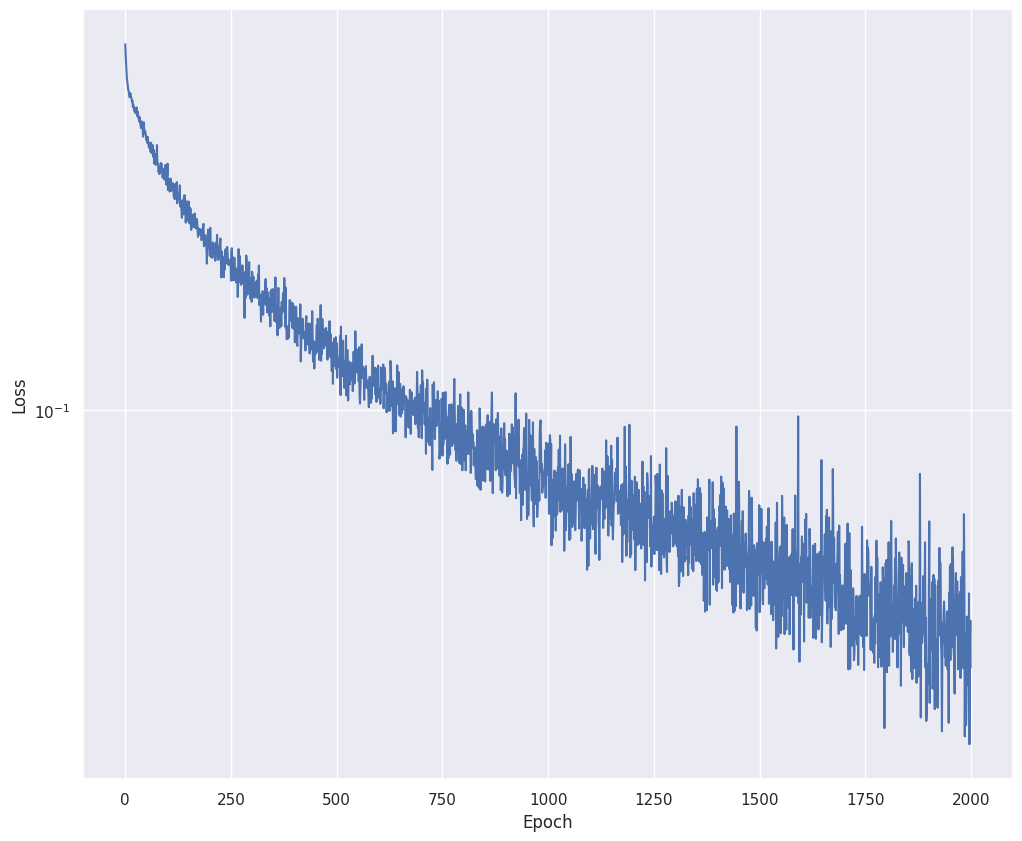

In [57]:
NN_function()

##### Selecting Features by a Threshold

In [58]:
def select_features(num, sorted_features, first_or_last='first'):
  if first_or_last == 'first':
    return sorted_features["features"][:num]
  elif first_or_last == 'last':
    return sorted_features["features"][-1*num:]

In [59]:
selected_sorted_features = select_features(10, tree_feature_selection, 'first')
GradientBoostingClassifier_function(selected_sorted_features)
KNN_function(selected_sorted_features)
LogisticRegression_function(selected_sorted_features)
# NN_function(selected_sorted_features)

Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
MCC score on the test set for GradientBoostingClassifier is: 0.60
Best hyperparameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 9}
MCC score on the test set for KNNClassifier is: 0.62
Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
MCC score on the test set for LogisticRegression is: 0.40


In [ ]:
selected_sorted_features = select_features(10, tree_feature_selection, 'last')
GradientBoostingClassifier_function(selected_sorted_features)
KNN_function(selected_sorted_features)
LogisticRegression_function(selected_sorted_features)

Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
MCC score on the test set for GradientBoostingClassifier is: 0.40


In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def NN_function(selected_features=total_features):
  model = Sequential()
  model.add(Dense(25, activation='relu', kernel_initializer='he_normal', input_shape=(len(selected_features),), kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(0.1))
  model.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(0.05))

  model.add(Dense(1, activation='sigmoid'))
  
  METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
  history = model.fit(stand_X_train_sm[selected_features], stand_y_train_sm, epochs=2000, batch_size=200, verbose=0)

  acc = model.evaluate(stand_X_test_sm[selected_features], stand_y_test_sm, verbose=0)

  print(acc)
  print("MCC score on the test set for NN is: {:.2f}".format(mcc(acc[1], acc[2], acc[3], acc[4])))

  plot_loss(history, "LOSS", 0)

In [ ]:
# selected_sorted_features = select_features(10, tree_feature_selection, 'first')
NN_function_10()

In [63]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def NN_function_10(selected_features=total_features):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_normal', input_shape=(len(selected_features),), kernel_regularizer=regularizers.l2(0.01)))
  # model.add(Dropout(0.1))
  # model.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(0.05))

  model.add(Dense(1, activation='sigmoid'))
  
  METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
  history = model.fit(stand_X_train_sm[selected_features], stand_y_train_sm, epochs=2000, batch_size=200, verbose=0)

  acc = model.evaluate(stand_X_test_sm[selected_features], stand_y_test_sm, verbose=0)

  print(acc)
  print("MCC score on the test set for NN is: {:.2f}".format(mcc(acc[1], acc[2], acc[3], acc[4])))

  plot_loss(history, "LOSS", 0)

[0.6556207537651062, 84.0, 41.0, 83.0, 44.0, 0.6626983880996704, 0.671999990940094, 0.65625, 0.6954070329666138, 0.7041364908218384]
MCC score on the test set for NN is: 0.33


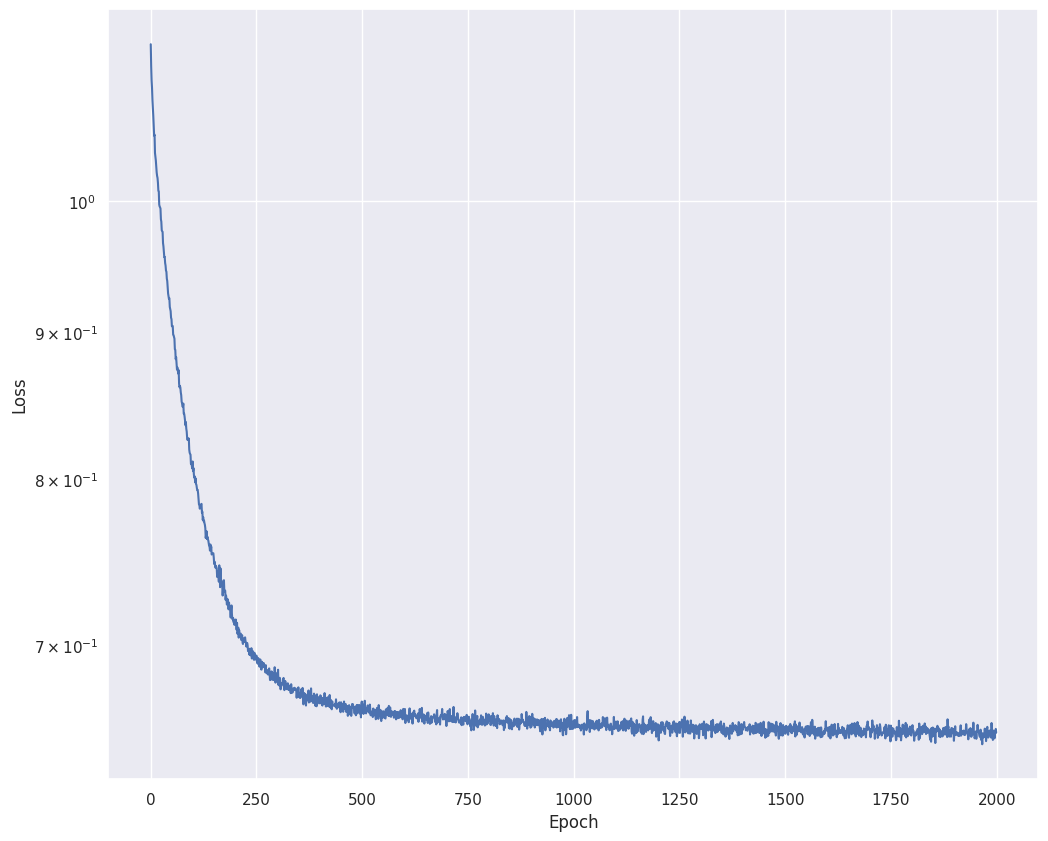

In [64]:
selected_sorted_features = select_features(10, tree_feature_selection, 'last')
NN_function_10(selected_sorted_features)

[0.48467835783958435, 96.0, 25.0, 99.0, 32.0, 0.773809552192688, 0.7933884263038635, 0.75, 0.8780242204666138, 0.9020403623580933]
MCC score on the test set for NN is: 0.55


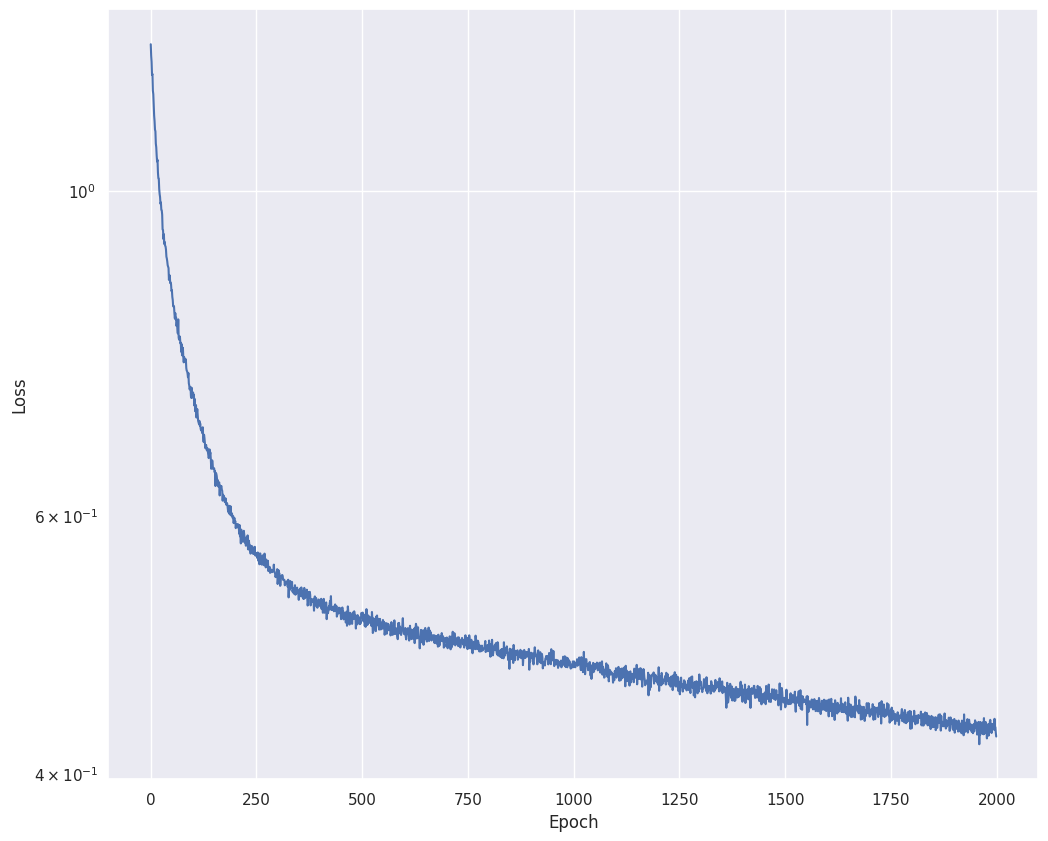

In [65]:
selected_sorted_features = select_features(10, tree_feature_selection, 'first')
NN_function_10(selected_sorted_features)

In [66]:
from scipy.stats import ttest_rel

mcc_before = 0.51
mcc_after = 0.44

t_statistic, p_value = ttest_rel([mcc_before], [mcc_after])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: nan
p-value: nan


In [67]:
stand_X_train_sm.duplicated().sum()

3